# With Parameter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/train_qso_wo_image.csv')
df_test = pd.read_csv('../data/train_qso_wo_image.csv')

In [3]:
data.columns

Index(['Unnamed: 0', 'ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'class_bin', 'RA', 'DEC', 'index', 'Unnamed: 0.1',
       'petroR50_g', 'petroR50_r'],
      dtype='object')

## Scaling

In [4]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
s.fit(data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']])
data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']] = s.transform(data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']])

## Train Test Split

In [5]:
X = data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']]

y = data['class_bin']

In [6]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 1)

In [7]:
from sklearn.dummy import DummyRegressor

base_line_model = DummyRegressor(strategy = 'mean').fit(X,y)

base_line_model.score(X,y)

0.0

## Model(modulos.ai parameters)

n_estimators: 730

log_min_samples_leaf: -3.686e+00

criterion: entropy

max_features: log2

class_weight: balanced_subsample 

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators = 730,
    criterion = "entropy",
    max_features = "sqrt",
    class_weight = "balanced_subsample"
    
)

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

### Metrics Output

- accuracy: 89.83%
- F1: 93.18%
- ROC_AUC: 95.2%

In [9]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('F1:', metrics.f1_score(y_test,y_pred))

Accuracy: 0.8983050847457628
F1: 0.9318181818181819


In [10]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[12,  4],
       [ 2, 41]])

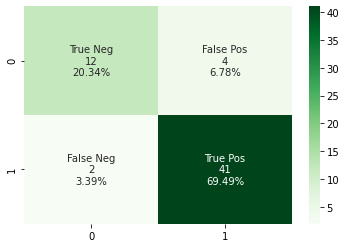

In [11]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

plt.savefig('../figures/rfc_p_cf_matrix')

In [12]:
#generate a no skill prediction
ns_prob = [0 for _ in range(len(y_test))]
#prodict probability
clf_prob = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only/
clf_prob = clf_prob[:, 1]

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_auc = roc_auc_score(y_test, ns_prob)
lr_auc = roc_auc_score(y_test, clf_prob)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.952


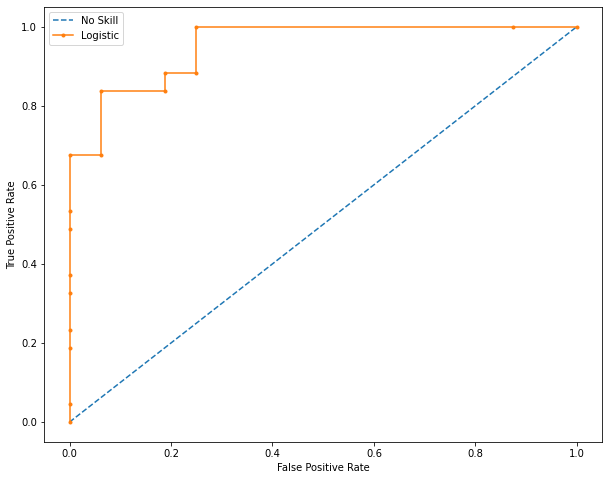

In [14]:
import matplotlib.pyplot as plt
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_prob)
lr_fpr, lr_tpr, _ = roc_curve(y_test, clf_prob)


plt.figure(figsize=(10, 8))
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.savefig('../figures/rfc_v1_rocauc.png')
# show the plot
plt.show()



In [15]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

ij            0.082052
gk            0.081709
gw1           0.062220
rw1           0.049771
ik            0.043875
zj            0.038659
iw1           0.037545
zk            0.037434
gz            0.036385
rz            0.032736
uk            0.029782
gi            0.029690
petroR50_r    0.028355
rw2           0.028325
uw1           0.026748
iw2           0.025856
jw2           0.025382
gw2           0.023702
ur            0.023417
uj            0.023013
ug            0.021836
zw1           0.020774
ri            0.020281
gr            0.019672
zw2           0.019194
jw1           0.018730
w1w2          0.018085
kw2           0.017926
uz            0.016610
iz            0.013901
ui            0.012408
petroR50_g    0.012217
kw1           0.011329
uw2           0.010378
dtype: float64

No handles with labels found to put in legend.


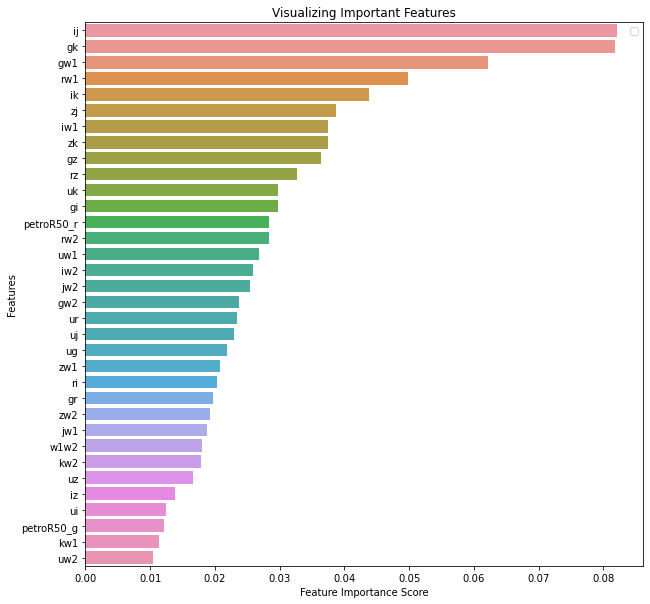

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10, 10))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.savefig('../figures/rfc_v1_features.png')
plt.show()



# Discussion

In [21]:
df = pd.read_csv('../data/train_qso.csv')

<AxesSubplot:xlabel='ij', ylabel='Count'>

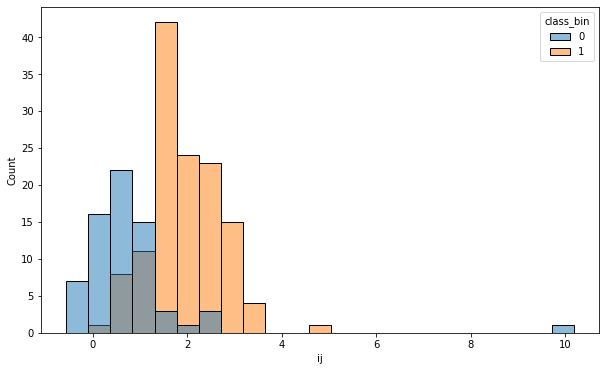

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="ij", hue="class_bin")

<AxesSubplot:xlabel='gk', ylabel='Count'>

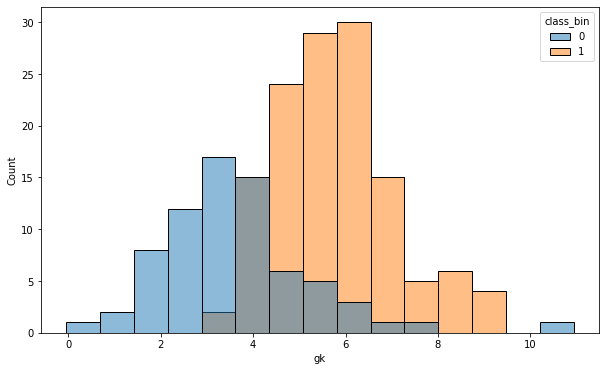

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="gk", hue="class_bin")

<AxesSubplot:xlabel='gw1', ylabel='Count'>

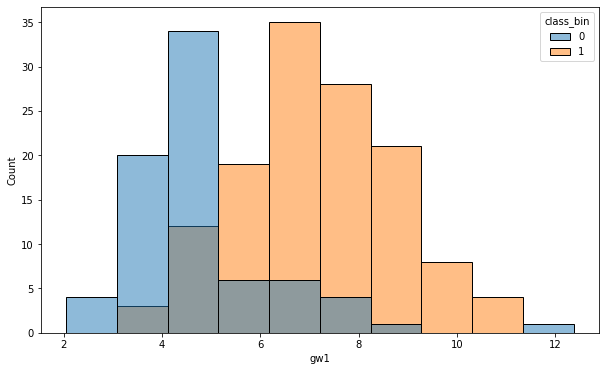

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="gw1", hue="class_bin")